In [1]:
# Import public packages and functions
import os
import pandas as pd
import numpy as np
import sys
import json
from pathlib import Path
from scipy import signal

import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

import warnings
warnings.filterwarnings("ignore")

# inserting the lib folder to the compiler
sys.path.insert(0, './lib')
sys.path.insert(0, './utils/')

import utils_io, utils_coherence, utils_plotting_coherence, utils_plotting

from lib_data import DATA_IO

In [2]:
PATH_CURR = os.path.abspath(os.curdir)    # current code
PATH      = (str(Path(PATH_CURR).parent)) # data repository: upper directory where datasets situated
fs        = 2048

# 1. Measure Baseline Coherence Between LFP and ECOG Channels

In [4]:
#baseline_coherence_LFP_ECOG = utils_coherence.extract_baseline_coherence_between_ECOG_LFP_channels()
#baseline_coherence_LFP_ECOG.to_pickle(DATA_IO.path_events + "coherence/ECOG_LFP_BASELINE_COHERENCE.pkl")
baseline_coherence_LFP_ECOG = pd.read_pickle(DATA_IO.path_events + "coherence/ECOG_LFP_BASELINE_COHERENCE.pkl")

## 1.1 Load Events

In [6]:
# load ECoG events
EVENTS_ECOG            = utils_io.load_ECoG_events(event_category="tapping", fs=2048)
EVENTS_ECOG_LID        = EVENTS_ECOG['controlateral']['LID']
EVENTS_ECOG_noLID      = EVENTS_ECOG['controlateral']['noLID']
# load LFP events
EVENTS_LFP             = utils_io.load_LFP_events(event_category="tapping", stn_areas=["motor"], fs=2048)
EVENTS_LFP_MOTOR_LID   = EVENTS_LFP['motor']['controlateral']['LID']
EVENTS_LFP_MOTOR_noLID = EVENTS_LFP['motor']['controlateral']['noLID']


KeyboardInterrupt



## 1.2 Pairwise-Coherence Between MOTOR-STN and ECOG Channels

In [11]:
coherence_motor_LID    = utils_coherence.measure_ECOG_LFP_coherence(dataset_LFP                         = EVENTS_LFP_MOTOR_LID, 
                                                                    dataset_ECOG                        = EVENTS_ECOG_LID, 
                                                                    dataset_baseline_LFP_ECOG_coherence = baseline_coherence_LFP_ECOG, 
                                                                    mode                                = "ipsilateral")

ECOG-LFP Channel Coherence Measurement Started...
---> Patient: 008
     LFP: left hemisphere - 04-01 | ECOG: left hemisphere - 02-01
     LFP: left hemisphere - 05-02 | ECOG: left hemisphere - 02-01
     LFP: left hemisphere - 06-03 | ECOG: left hemisphere - 02-01
     LFP: left hemisphere - 07-04 | ECOG: left hemisphere - 02-01
     LFP: left hemisphere - 08-05 | ECOG: left hemisphere - 02-01
     LFP: left hemisphere - 09-06 | ECOG: left hemisphere - 02-01
     LFP: left hemisphere - 10-07 | ECOG: left hemisphere - 02-01
     LFP: left hemisphere - 11-08 | ECOG: left hemisphere - 02-01
     LFP: left hemisphere - 11-09 | ECOG: left hemisphere - 02-01
     LFP: left hemisphere - 13-10 | ECOG: left hemisphere - 02-01
     LFP: left hemisphere - 14-11 | ECOG: left hemisphere - 02-01
     LFP: left hemisphere - 04-01 | ECOG: left hemisphere - 03-02
     LFP: left hemisphere - 05-02 | ECOG: left hemisphere - 03-02
     LFP: left hemisphere - 06-03 | ECOG: left hemisphere - 03-02
     LFP

In [12]:
coherence_motor_noLID  = utils_coherence.measure_ECOG_LFP_coherence(dataset_LFP                         = EVENTS_LFP_MOTOR_noLID,
                                                                    dataset_ECOG                        = EVENTS_ECOG_noLID, 
                                                                    dataset_baseline_LFP_ECOG_coherence = baseline_coherence_LFP_ECOG, 
                                                                    mode                                = "ipsilateral")

ECOG-LFP Channel Coherence Measurement Started...
---> Patient: 009
     LFP: left hemisphere - 02-01 | ECOG: left hemisphere - 02-01
     LFP: left hemisphere - 03-01 | ECOG: left hemisphere - 02-01
     LFP: left hemisphere - 04-01 | ECOG: left hemisphere - 02-01
     LFP: left hemisphere - 06-03 | ECOG: left hemisphere - 02-01
     LFP: left hemisphere - 08-06 | ECOG: left hemisphere - 02-01
     LFP: left hemisphere - 02-01 | ECOG: left hemisphere - 03-02
     LFP: left hemisphere - 03-01 | ECOG: left hemisphere - 03-02
     LFP: left hemisphere - 04-01 | ECOG: left hemisphere - 03-02
     LFP: left hemisphere - 06-03 | ECOG: left hemisphere - 03-02
     LFP: left hemisphere - 08-06 | ECOG: left hemisphere - 03-02
     LFP: left hemisphere - 02-01 | ECOG: left hemisphere - 04-03
     LFP: left hemisphere - 03-01 | ECOG: left hemisphere - 04-03
     LFP: left hemisphere - 04-01 | ECOG: left hemisphere - 04-03
     LFP: left hemisphere - 06-03 | ECOG: left hemisphere - 04-03
     LFP

In [13]:
coherence_motor_LID.to_pickle(DATA_IO.path_events + "coherence/STN_MOTOR_vs_Cortex_Coherence_LID.pkl")
coherence_motor_noLID.to_pickle(DATA_IO.path_events + "coherence/STN_MOTOR_vs_Cortex_Coherence_noLID.pkl")

# 2. Statistical Test

In [5]:
def built_lme_and_fit(dataset, feature):
    
    import statsmodels.formula.api as smf

    subset  = dataset[dataset[feature].notna()]
    model   = smf.mixedlm(formula    = f"{feature} ~ state",
                          data       = subset, 
                          groups     = subset["patient"],
                          vc_formula = {"event": "0 + C(event_no)"})  # random intercept per event_no, nested
    result  = model.fit()

    coef    = result.fe_params["state"]
    p_value = result.pvalues["state"]
    std_err = result.bse["state"]
    z_stat  = coef/std_err
    return [coef, p_value, z_stat]

def collect_lme_results_across_features(dataset, features, ref_group, comp_group):
    from statsmodels.stats.multitest import multipletests

    def get_segment(feature):
        if feature.startswith("pre_event"):
            return "pre_event"
        elif feature.startswith("event"):
            return "event"
        elif feature.startswith("post_event"):
            return "post_event"
        else:
            return "other"
            
    lme_results = []
    data        = dataset.copy()
    for feature in features:
        lme_results.append(built_lme_and_fit(data, feature))
    
    lme_results                     = pd.DataFrame(data=lme_results, columns=["coefficient", "pvalue",  "z_stat"])
    lme_results["pvalue_corrected"] = multipletests(lme_results.pvalue.to_list(), method='holm')[1]
    lme_results["feature"]          = features
    lme_results["segment"]          = lme_results["feature"].apply(get_segment)
    lme_results['frequency_band']   = (lme_results['feature']
                                       .str.replace('event_', '', regex=False)
                                       .str.replace('pre_', '', regex=False)
                                       .str.replace('post_', '', regex=False)
                                       .str.replace('_mean', '', regex=False))
    lme_results["reference_group"]  = ref_group
    lme_results["comparison_group"] = comp_group  
    return lme_results

In [7]:
coherence_motor_LID    = pd.read_pickle(DATA_IO.path_events + "coherence/STN_MOTOR_vs_Cortex_Coherence_LID.pkl")
coherence_motor_noLID  = pd.read_pickle(DATA_IO.path_events + "coherence/STN_MOTOR_vs_Cortex_Coherence_noLID.pkl")

coherence_noLID_noDOPA = coherence_motor_noLID[coherence_motor_noLID.event_start_time <= 30]
coherence_noLID_DOPA   = coherence_motor_noLID[coherence_motor_noLID.event_start_time >  30]
coherence_LID          = coherence_motor_LID

# get sensorymotor STN borders (dorsal vs ventral)
MNI_STN                = pd.read_pickle(DATA_IO.path_events + "LFP_channel_MNI.pkl")
MNI_STN['patient']     = MNI_STN['patient'].astype(object)

# set state column
coherence_noLID_noDOPA["state"] = "noLID_noDOPA"
coherence_noLID_DOPA["state"]   = "noLID_DOPA"
coherence_LID["state"]          = "LID"

# merge STN channel position information to the dataframe
coherence_noLID_noDOPA = coherence_noLID_noDOPA.merge(MNI_STN[['patient', 'hemisphere', 'channel', 'position_dorsoventral']],
                                                      how='left', left_on=['patient', 'LFP_hemisphere', 'LFP_channel'], 
                                                      right_on=['patient', 'hemisphere', 'channel']) 
coherence_noLID_DOPA   = coherence_noLID_DOPA.merge(MNI_STN[['patient', 'hemisphere', 'channel', 'position_dorsoventral']],
                                                    how='left', left_on=['patient', 'LFP_hemisphere', 'LFP_channel'], 
                                                    right_on=['patient', 'hemisphere', 'channel']) 
coherence_LID          = coherence_LID.merge(MNI_STN[['patient', 'hemisphere', 'channel', 'position_dorsoventral']],
                                             how='left', left_on=['patient', 'LFP_hemisphere', 'LFP_channel'], right_on=['patient', 'hemisphere', 'channel']) 

coherence_noLID_noDOPA = coherence_noLID_noDOPA.drop(columns=['hemisphere', 'channel'])
coherence_noLID_DOPA   = coherence_noLID_DOPA.drop(columns=['hemisphere', 'channel'])
coherence_LID          = coherence_LID.drop(columns=['hemisphere', 'channel'])

# measure mean features
coherence_noLID_noDOPA = utils_coherence.measure_mean_coherence_by_frequency_band(coherence_noLID_noDOPA)
coherence_noLID_DOPA   = utils_coherence.measure_mean_coherence_by_frequency_band(coherence_noLID_DOPA)
coherence_LID          = utils_coherence.measure_mean_coherence_by_frequency_band(coherence_LID)

coherence_mean_dataset         = pd.concat([coherence_noLID_noDOPA, coherence_noLID_DOPA, coherence_LID], ignore_index=True)
coherence_mean_dataset_dorsal  = coherence_mean_dataset[coherence_mean_dataset.position_dorsoventral=="dorsal"]
coherence_mean_dataset_ventral = coherence_mean_dataset[coherence_mean_dataset.position_dorsoventral=="ventral"]
coherence_mean_dataset = coherence_mean_dataset[["patient", "event_no", "LFP_hemisphere", "LFP_channel", "ECoG_hemisphere", "ECoG_channel", "position_dorsoventral", "state", 
                                                 "pre_event_theta_mean","pre_event_alpha_mean","pre_event_beta_low_mean","pre_event_beta_high_mean","pre_event_gamma_mean","pre_event_gamma_III_mean",
                                                 "event_theta_mean","event_alpha_mean","event_beta_low_mean","event_beta_high_mean","event_gamma_mean", "event_gamma_III_mean",
                                                 "post_event_theta_mean","post_event_alpha_mean","post_event_beta_low_mean","post_event_beta_high_mean","post_event_gamma_mean", "post_event_gamma_III_mean"]]

features = ['pre_event_theta_mean', 'pre_event_alpha_mean', 'pre_event_beta_low_mean',
            'pre_event_beta_high_mean','pre_event_gamma_mean',
            'event_theta_mean', 'event_alpha_mean', 'event_beta_low_mean',
            'event_beta_high_mean','event_gamma_mean', 
            'post_event_theta_mean', 'post_event_alpha_mean',
            'post_event_beta_low_mean','post_event_beta_high_mean','post_event_gamma_mean', "pre_event_gamma_III_mean", "event_gamma_III_mean","post_event_gamma_III_mean"]

## 2.1 Whole SensoryMotor STN

In [10]:
dataset_noLIDnoDOPA_vs_noLIDDOPA       = coherence_mean_dataset[coherence_mean_dataset.state!="LID"].copy()
dataset_noLIDnoDOPA_vs_noLIDDOPA.state = dataset_noLIDnoDOPA_vs_noLIDDOPA.state.map({'noLID_noDOPA': 0, 'noLID_DOPA': 1})
dataset_noLIDnoDOPA_vs_noLIDDOPA.reset_index(drop=True, inplace=True)

dataset_noLIDDOPA_vs_LID               = coherence_mean_dataset_dorsal[coherence_mean_dataset_dorsal.state!="noLID_noDOPA"].copy()
dataset_noLIDDOPA_vs_LID.state         = dataset_noLIDDOPA_vs_LID.state.map({'noLID_DOPA': 0, 'LID': 1})
dataset_noLIDDOPA_vs_LID.reset_index(drop=True, inplace=True)

DOPA_OFF_vs_DOPA_ON                    = collect_lme_results_across_features(dataset_noLIDnoDOPA_vs_noLIDDOPA, features, ref_group="noLIDnoDOPA", comp_group="noLID_DOPA")
DOPA_ON_vs_LID                         = collect_lme_results_across_features(dataset_noLIDDOPA_vs_LID, features, ref_group="noLID_DOPA", comp_group="LID")
lme_SM_STN                             = pd.concat([DOPA_OFF_vs_DOPA_ON, DOPA_ON_vs_LID], ignore_index=True)

## 2.2 Dorsal SensoryMotor STN

In [14]:
dataset_noLIDnoDOPA_vs_noLIDDOPA       = coherence_mean_dataset_dorsal[coherence_mean_dataset_dorsal.state!="LID"].copy()
dataset_noLIDnoDOPA_vs_noLIDDOPA.state = dataset_noLIDnoDOPA_vs_noLIDDOPA.state.map({'noLID_noDOPA': 0, 'noLID_DOPA': 1})
dataset_noLIDnoDOPA_vs_noLIDDOPA.reset_index(drop=True, inplace=True)

dataset_noLIDDOPA_vs_LID               = coherence_mean_dataset_dorsal[coherence_mean_dataset_dorsal.state!="noLID_noDOPA"].copy()
dataset_noLIDDOPA_vs_LID.state         = dataset_noLIDDOPA_vs_LID.state.map({'noLID_DOPA': 0, 'LID': 1})
dataset_noLIDDOPA_vs_LID.reset_index(drop=True, inplace=True)

DOPA_OFF_vs_DOPA_ON                    = collect_lme_results_across_features(dataset_noLIDnoDOPA_vs_noLIDDOPA, features, ref_group="noLIDnoDOPA", comp_group="noLID_DOPA")
DOPA_ON_vs_LID                         = collect_lme_results_across_features(dataset_noLIDDOPA_vs_LID, features, ref_group="noLID_DOPA", comp_group="LID")
lme_SM_STN_DORSAL                      = pd.concat([DOPA_OFF_vs_DOPA_ON, DOPA_ON_vs_LID], ignore_index=True)

## 2.3 Ventral SensoryMotor STN

In [16]:
dataset_noLIDnoDOPA_vs_noLIDDOPA       = coherence_mean_dataset_ventral[coherence_mean_dataset_ventral.state!="LID"].copy()
dataset_noLIDnoDOPA_vs_noLIDDOPA.state = dataset_noLIDnoDOPA_vs_noLIDDOPA.state.map({'noLID_noDOPA': 0, 'noLID_DOPA': 1})
dataset_noLIDnoDOPA_vs_noLIDDOPA.reset_index(drop=True, inplace=True)

dataset_noLIDDOPA_vs_LID               = coherence_mean_dataset_ventral[coherence_mean_dataset_ventral.state!="noLID_noDOPA"].copy()
dataset_noLIDDOPA_vs_LID.state         = dataset_noLIDDOPA_vs_LID.state.map({'noLID_DOPA': 0, 'LID': 1})
dataset_noLIDDOPA_vs_LID.reset_index(drop=True, inplace=True)

DOPA_OFF_vs_DOPA_ON                    = collect_lme_results_across_features(dataset_noLIDnoDOPA_vs_noLIDDOPA, features, ref_group="noLIDnoDOPA", comp_group="noLID_DOPA")
DOPA_ON_vs_LID                         = collect_lme_results_across_features(dataset_noLIDDOPA_vs_LID, features, ref_group="noLID_DOPA", comp_group="LID")
lme_SM_STN_VENTRAL                     = pd.concat([DOPA_OFF_vs_DOPA_ON, DOPA_ON_vs_LID], ignore_index=True)

# 3.Plotting

In [3]:
coherence_motor_LID    = pd.read_pickle(DATA_IO.path_events + "coherence/STN_MOTOR_vs_Cortex_Coherence_LID.pkl")
coherence_motor_noLID  = pd.read_pickle(DATA_IO.path_events + "coherence/STN_MOTOR_vs_Cortex_Coherence_noLID.pkl")

coherence_noLID_noDOPA = coherence_motor_noLID[coherence_motor_noLID.event_start_time <= 30]
coherence_noLID_DOPA   = coherence_motor_noLID[coherence_motor_noLID.event_start_time >  30]
coherence_LID          = coherence_motor_LID

## 3.1 Full STN

<Figure size 640x480 with 0 Axes>

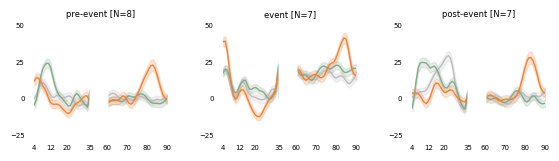

In [5]:
# get the coherence array of selected event segment
freq     = np.linspace(4,100,97) # fixed

plt      = utils_plotting.get_figure_template()
ax_pre   = plt.subplot2grid((80, 42), (0, 0) , colspan=10, rowspan=14)
ax_event = plt.subplot2grid((80, 42), (0, 14), colspan=10, rowspan=14)
ax_post  = plt.subplot2grid((80, 42), (0, 28), colspan=10, rowspan=14)
    
ax_pre   = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_noDOPA.pre_event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_noDOPA"], axis=ax_pre)
ax_pre   = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_DOPA.pre_event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_DOPA"]  , axis=ax_pre)
ax_pre   = utils_plotting_coherence.plot_coherence_panel(freq, coherence_LID.pre_event_coherence.to_list(),
                                                         error_type="se", color=utils_plotting.colors["LID"]         , axis=ax_pre)


ax_event = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_noDOPA.event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_noDOPA"], axis=ax_event)
ax_event = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_DOPA.event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_DOPA"]  , axis=ax_event)
ax_event = utils_plotting_coherence.plot_coherence_panel(freq, coherence_LID.event_coherence.to_list(),
                                                         error_type="se", color=utils_plotting.colors["LID"]         , axis=ax_event)

ax_post  = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_noDOPA.post_event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_noDOPA"], axis=ax_post)
ax_post  = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_DOPA.post_event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_DOPA"]  , axis=ax_post)
ax_post  = utils_plotting_coherence.plot_coherence_panel(freq, coherence_LID.post_event_coherence.to_list(),
                                                         error_type="se", color=utils_plotting.colors["LID"]         , axis=ax_post)
    
ax_pre.set_title(f"pre-event [N={coherence_noLID_noDOPA.patient.nunique()}]", fontsize=utils_plotting.LABEL_SIZE_label)
ax_event.set_title(f"event [N={coherence_noLID_DOPA.patient.nunique()}]", fontsize=utils_plotting.LABEL_SIZE_label)
ax_post.set_title(f"post-event [N={coherence_LID.patient.nunique()}]", fontsize=utils_plotting.LABEL_SIZE_label)

ax_pre.set_ylim([-25,50])
ax_event.set_ylim([-25,50])
ax_post.set_ylim([-25,50])

utils_plotting.set_axis(ax_pre)
utils_plotting.set_axis(ax_event)
utils_plotting.set_axis(ax_post)

plt.savefig(DATA_IO.path_figure + "LFP-ECOG Coherence/mean_coherence.svg", dpi=300)

## 3.2 Dorsal STN

In [10]:
import utils_MER
def assign_dorsoventral(row):
    threshold_right = (STN_meshes["right"]["stn_SM"].bounds[4] + STN_meshes["right"]["stn_SM"].bounds[5]) / 2
    threshold_left  = (STN_meshes["left"]["stn_SM"].bounds[4] + STN_meshes["left"]["stn_SM"].bounds[5]) / 2
    if row['hemisphere'] == 'left': return 'ventral' if row['z'] <= threshold_left else 'dorsal'
    else: return 'ventral' if row['z'] <= threshold_right else 'dorsal'

MNI_STN            = pd.read_pickle(DATA_IO.path_events + "LFP_channel_MNI.pkl")
MNI_STN['patient'] = MNI_STN['patient'].astype(object)
#MNI_STN['position_dorsoventral'] = MNI_STN.apply(assign_dorsoventral, axis=1)
#MNI_STN.to_pickle("LFP_channel_MNI.pkl")

In [13]:
coherence_noLID_noDOPA = coherence_motor_noLID[coherence_motor_noLID.event_start_time <= 30]
coherence_noLID_DOPA   = coherence_motor_noLID[coherence_motor_noLID.event_start_time >  30]
coherence_LID          = coherence_motor_LID

# set state column
coherence_noLID_noDOPA["state"] = "noLID_noDOPA"
coherence_noLID_DOPA["state"]   = "noLID_DOPA"
coherence_LID["state"]          = "LID"

# merge STN channel position information to the dataframe
coherence_noLID_noDOPA = coherence_noLID_noDOPA.merge(MNI_STN[['patient', 'hemisphere', 'channel', 'position_dorsoventral']],
                                                      how='left', left_on=['patient', 'LFP_hemisphere', 'LFP_channel'], 
                                                      right_on=['patient', 'hemisphere', 'channel']) 
coherence_noLID_DOPA   = coherence_noLID_DOPA.merge(MNI_STN[['patient', 'hemisphere', 'channel', 'position_dorsoventral']],
                                                    how='left', left_on=['patient', 'LFP_hemisphere', 'LFP_channel'], 
                                                    right_on=['patient', 'hemisphere', 'channel']) 
coherence_LID          = coherence_LID.merge(MNI_STN[['patient', 'hemisphere', 'channel', 'position_dorsoventral']],
                                             how='left', left_on=['patient', 'LFP_hemisphere', 'LFP_channel'], right_on=['patient', 'hemisphere', 'channel']) 

coherence_noLID_noDOPA = coherence_noLID_noDOPA.drop(columns=['hemisphere', 'channel'])
coherence_noLID_DOPA   = coherence_noLID_DOPA.drop(columns=['hemisphere', 'channel'])
coherence_LID          = coherence_LID.drop(columns=['hemisphere', 'channel'])

<Figure size 640x480 with 0 Axes>

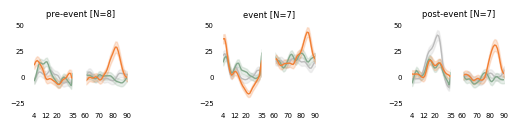

In [15]:
# get the coherence array of selected event segment
freq     = np.linspace(4,100,97) # fixed

plt      = utils_plotting.get_figure_template()
ax_pre   = plt.subplot2grid((80, 42), (0, 0) , colspan=7, rowspan=10)
ax_event = plt.subplot2grid((80, 42), (0, 14), colspan=7, rowspan=10)
ax_post  = plt.subplot2grid((80, 42), (0, 28), colspan=7, rowspan=10)
    
ax_pre   = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_noDOPA[coherence_noLID_noDOPA.position_dorsoventral=="dorsal"].pre_event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_noDOPA"], axis=ax_pre)
ax_pre   = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_DOPA[coherence_noLID_DOPA.position_dorsoventral=="dorsal"].pre_event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_DOPA"]  , axis=ax_pre)
ax_pre   = utils_plotting_coherence.plot_coherence_panel(freq, coherence_LID[coherence_LID.position_dorsoventral=="dorsal"].pre_event_coherence.to_list(),
                                                         error_type="se", color=utils_plotting.colors["LID"]         , axis=ax_pre)


ax_event = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_noDOPA[coherence_noLID_noDOPA.position_dorsoventral=="dorsal"].event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_noDOPA"], axis=ax_event)
ax_event = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_DOPA[coherence_noLID_DOPA.position_dorsoventral=="dorsal"].event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_DOPA"]  , axis=ax_event)
ax_event = utils_plotting_coherence.plot_coherence_panel(freq, coherence_LID[coherence_LID.position_dorsoventral=="dorsal"].event_coherence.to_list(),
                                                         error_type="se", color=utils_plotting.colors["LID"]         , axis=ax_event)

ax_post  = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_noDOPA[coherence_noLID_noDOPA.position_dorsoventral=="dorsal"].post_event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_noDOPA"], axis=ax_post)
ax_post  = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_DOPA[coherence_noLID_DOPA.position_dorsoventral=="dorsal"].post_event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_DOPA"]  , axis=ax_post)
ax_post  = utils_plotting_coherence.plot_coherence_panel(freq, coherence_LID[coherence_LID.position_dorsoventral=="dorsal"].post_event_coherence.to_list(),
                                                         error_type="se", color=utils_plotting.colors["LID"]         , axis=ax_post)
    
ax_pre.set_title(f"pre-event [N={coherence_noLID_noDOPA.patient.nunique()}]", fontsize=utils_plotting.LABEL_SIZE_label)
ax_event.set_title(f"event [N={coherence_noLID_DOPA.patient.nunique()}]", fontsize=utils_plotting.LABEL_SIZE_label)
ax_post.set_title(f"post-event [N={coherence_LID.patient.nunique()}]", fontsize=utils_plotting.LABEL_SIZE_label)

ax_pre.set_ylim([-25,50])
ax_event.set_ylim([-25,50])
ax_post.set_ylim([-25,50])

utils_plotting.set_axis(ax_pre)
utils_plotting.set_axis(ax_event)
utils_plotting.set_axis(ax_post)

plt.savefig(DATA_IO.path_figure + "LFP-ECOG Coherence/mean_coherence_dorsal_STN.svg", dpi=300)

## 3.3 Ventral STN

<Figure size 640x480 with 0 Axes>

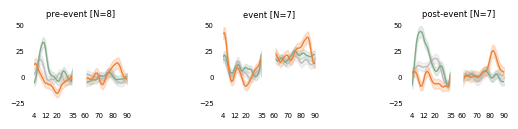

In [18]:
# get the coherence array of selected event segment
freq     = np.linspace(4,100,97) # fixed

plt      = utils_plotting.get_figure_template()
ax_pre   = plt.subplot2grid((80, 42), (0, 0) , colspan=7, rowspan=10)
ax_event = plt.subplot2grid((80, 42), (0, 14), colspan=7, rowspan=10)
ax_post  = plt.subplot2grid((80, 42), (0, 28), colspan=7, rowspan=10)
    
ax_pre   = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_noDOPA[coherence_noLID_noDOPA.position_dorsoventral=="ventral"].pre_event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_noDOPA"], axis=ax_pre)
ax_pre   = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_DOPA[coherence_noLID_DOPA.position_dorsoventral=="ventral"].pre_event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_DOPA"]  , axis=ax_pre)
ax_pre   = utils_plotting_coherence.plot_coherence_panel(freq, coherence_LID[coherence_LID.position_dorsoventral=="ventral"].pre_event_coherence.to_list(),
                                                         error_type="se", color=utils_plotting.colors["LID"]         , axis=ax_pre)


ax_event = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_noDOPA[coherence_noLID_noDOPA.position_dorsoventral=="ventral"].event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_noDOPA"], axis=ax_event)
ax_event = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_DOPA[coherence_noLID_DOPA.position_dorsoventral=="ventral"].event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_DOPA"]  , axis=ax_event)
ax_event = utils_plotting_coherence.plot_coherence_panel(freq, coherence_LID[coherence_LID.position_dorsoventral=="ventral"].event_coherence.to_list(),
                                                         error_type="se", color=utils_plotting.colors["LID"]         , axis=ax_event)

ax_post  = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_noDOPA[coherence_noLID_noDOPA.position_dorsoventral=="ventral"].post_event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_noDOPA"], axis=ax_post)
ax_post  = utils_plotting_coherence.plot_coherence_panel(freq, coherence_noLID_DOPA[coherence_noLID_DOPA.position_dorsoventral=="ventral"].post_event_coherence.to_list(), 
                                                         error_type="se", color=utils_plotting.colors["noLID_DOPA"]  , axis=ax_post)
ax_post  = utils_plotting_coherence.plot_coherence_panel(freq, coherence_LID[coherence_LID.position_dorsoventral=="ventral"].post_event_coherence.to_list(),
                                                         error_type="se", color=utils_plotting.colors["LID"]         , axis=ax_post)
    
ax_pre.set_title(f"pre-event [N={coherence_noLID_noDOPA.patient.nunique()}]", fontsize=utils_plotting.LABEL_SIZE_label)
ax_event.set_title(f"event [N={coherence_noLID_DOPA.patient.nunique()}]", fontsize=utils_plotting.LABEL_SIZE_label)
ax_post.set_title(f"post-event [N={coherence_LID.patient.nunique()}]", fontsize=utils_plotting.LABEL_SIZE_label)

ax_pre.set_ylim([-25,50])
ax_event.set_ylim([-25,50])
ax_post.set_ylim([-25,50])

utils_plotting.set_axis(ax_pre)
utils_plotting.set_axis(ax_event)
utils_plotting.set_axis(ax_post)

plt.savefig(DATA_IO.path_figure + "LFP-ECOG Coherence/mean_coherence_ventral_STN.svg", dpi=300)

## 3.4 LME (DOPA OFF - DOPA ON & DOPA ON - LID)

In [84]:
def plot_stats(data, event_segment, reference_group, comparison_group, axis):

    dataset          = data[(data.reference_group==reference_group) & (data.comparison_group==comparison_group)].copy()
    dataset['color'] = np.where(dataset['pvalue_corrected'] > 0.05,'#ccccccff',  # non-significant
                                np.where(dataset['coefficient'] > 0,
                                         '#99e2b4ff',  # significant positive
                                         '#ef3c2dff'   # significant negative
                                        )
                               )
    data_subset      = dataset[dataset.segment==event_segment]
    axis             = sns.scatterplot(data=data_subset, y="frequency_band", x='z_stat', 
                                       c=data_subset.color.to_list(), s=15, ax=axis)
    axis.set_xlim([-6,6])
    axis.set_yticklabels(axis.get_yticklabels(), fontsize=utils_plotting.LABEL_SIZE, rotation=0)
    utils_plotting.set_axis(axis)

    return axis

<Figure size 640x480 with 0 Axes>

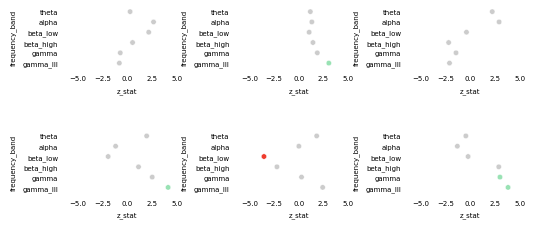

In [86]:
plt = utils_plotting.get_figure_template()
ax1 = plt.subplot2grid((77, 66), (0, 0)  , colspan=14, rowspan=7)
ax2 = plt.subplot2grid((77, 66), (0, 20) , colspan=14, rowspan=7)
ax3 = plt.subplot2grid((77, 66), (0, 40) , colspan=14, rowspan=7)

ax4 = plt.subplot2grid((77, 66), (15, 0) , colspan=14, rowspan=7)
ax5 = plt.subplot2grid((77, 66), (15, 20), colspan=14, rowspan=7)
ax6 = plt.subplot2grid((77, 66), (15, 40), colspan=14, rowspan=7)

ax1 = plot_stats(lme_SM_STN, event_segment="pre_event" , reference_group="noLIDnoDOPA", comparison_group="noLID_DOPA", axis=ax1)
ax2 = plot_stats(lme_SM_STN, event_segment="event"     , reference_group="noLIDnoDOPA", comparison_group="noLID_DOPA", axis=ax2)
ax3 = plot_stats(lme_SM_STN, event_segment="post_event", reference_group="noLIDnoDOPA", comparison_group="noLID_DOPA", axis=ax3)

ax4 = plot_stats(lme_SM_STN, event_segment="pre_event" , reference_group="noLID_DOPA", comparison_group="LID", axis=ax4)
ax5 = plot_stats(lme_SM_STN, event_segment="event"     , reference_group="noLID_DOPA", comparison_group="LID", axis=ax5)
ax6 = plot_stats(lme_SM_STN, event_segment="post_event", reference_group="noLID_DOPA", comparison_group="LID", axis=ax6)

plt.savefig(DATA_IO.path_figure + "LFP-ECOG Coherence/lme_SM_STN_coherence.svg", dpi=1200)

In [88]:
lme_SM_STN_DORSAL[lme_SM_STN_DORSAL.pvalue_corrected<=0.05]

,coefficient,pvalue,z_stat,pvalue_corrected,feature,segment,frequency_band,reference_group,comparison_group
25,-10.395736,0.000441,-3.514200,0.007057,event_beta_low_mean,event,beta_low,noLID_DOPA,LID
32,6.453143,0.002581,3.013684,0.038715,post_event_gamma_mean,post_event,gamma,noLID_DOPA,LID
33,14.405204,0.000035,4.137813,0.000631,pre_event_gamma_III_mean,pre_event,gamma_III,noLID_DOPA,LID
35,15.297817,0.000127,3.832755,0.002154,post_event_gamma_III_mean,post_event,gamma_III,noLID_DOPA,LID


In [90]:
lme_SM_STN_VENTRAL[lme_SM_STN_VENTRAL.pvalue_corrected<=0.05]

,coefficient,pvalue,z_stat,pvalue_corrected,feature,segment,frequency_band,reference_group,comparison_group
11,25.181242,0.000269,3.643021,0.004850,post_event_alpha_mean,post_event,alpha,noLIDnoDOPA,noLID_DOPA
20,-13.183654,0.000416,-3.529627,0.006658,pre_event_beta_low_mean,pre_event,beta_low,noLID_DOPA,LID
29,-32.789951,0.000018,-4.290230,0.000321,post_event_alpha_mean,post_event,alpha,noLID_DOPA,LID
30,-15.479983,0.001595,-3.156745,0.023931,post_event_beta_low_mean,post_event,beta_low,noLID_DOPA,LID
35,13.221002,0.000037,4.126333,0.000627,post_event_gamma_III_mean,post_event,gamma_III,noLID_DOPA,LID
